<a href="https://colab.research.google.com/github/manojan143/ML_Projects/blob/main/Project7_Heart_Disease_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =============================
# STEP 0: Install (Colab)
# =============================
# (uncomment if packages not present)
!pip install seaborn imbalanced-learn shap --quiet


In [ ]:
# =============================
# STEP 1: Imports
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

# for imbalance handling
from imblearn.over_sampling import SMOTE

# optional SHAP (explainability)
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False


In [ ]:
# =============================
# STEP 2: Upload Dataset
# =============================
from google.colab import files, drive
uploaded = files.upload()

import io
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print("Loaded:", filename)
df.head()


Saving framingham.csv to framingham (2).csv
Loaded: framingham (2).csv


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [ ]:
# =============================
# STEP 3: Quick EDA
# =============================
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nMissing values:\n", df.isnull().sum())
print("\nTarget value counts (if named 'target' or 'heart_disease'):")
# Try to guess target column names common in heart disease datasets
for tcol in ['target','HeartDisease','heart_disease','disease','output','y']:
    if tcol in df.columns:
        print(tcol, "counts:\n", df[tcol].value_counts())
# You can rename target if needed; below we'll ask you to set target_col variable


Shape: (4240, 16)

Columns:
 ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD']

Missing values:
 male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

Target value counts (if named 'target' or 'heart_disease'):


In [ ]:
# =============================
# STEP 4: Set target & features
# =============================
target_col = 'TenYearCHD'   # corrected target column name

if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found. Available columns: {df.columns.tolist()}")

# If target is categorical strings, encode to 0/1
if df[target_col].dtype == 'object':
    df[target_col] = df[target_col].map(
        lambda x: 1 if str(x).lower() in ['yes','y','1','true','positive','m','disease','present'] else 0
    )

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

print("Features:", X.shape)
print("Target distribution:\n", y.value_counts())


Features: (4240, 15)
Target distribution:
 TenYearCHD
0    3596
1     644
Name: count, dtype: int64


In [ ]:
# =============================
# STEP 5: Preprocessing pipeline
# - Separate numeric & categorical (simple handling)
# - Impute numeric with median, categorical with mode
# - One-hot encode small-cardinality categorical features
# - Scale numeric features
# =============================
# Identify categorical cols
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("Numeric cols:", len(num_cols), "Categorical cols:", len(cat_cols))

# Impute numeric
num_imputer = SimpleImputer(strategy='median')
X_num = pd.DataFrame(num_imputer.fit_transform(X[num_cols]), columns=num_cols)

# Impute categorical & encode
if len(cat_cols) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X_cat = pd.DataFrame(cat_imputer.fit_transform(X[cat_cols]), columns=cat_cols)
    # One-hot encode categorical columns with reasonable number of unique values
    X_cat = pd.get_dummies(X_cat, drop_first=True)
else:
    X_cat = pd.DataFrame(index=X.index)

# Combine
X_pre = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)

# Scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_pre), columns=X_pre.columns)

print("Preprocessing finished. Final feature count:", X_scaled.shape[1])


Numeric cols: 15 Categorical cols: 0
Preprocessing finished. Final feature count: 15


In [ ]:
# =============================
# STEP 6: Train-test split
# =============================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("Train/Test shapes:", X_train.shape, X_test.shape)
print("Train target distribution:\n", y_train.value_counts())


Train/Test shapes: (3392, 15) (848, 15)
Train target distribution:
 TenYearCHD
0    2877
1     515
Name: count, dtype: int64


In [ ]:
# =============================
# STEP 7: Handle class imbalance (SMOTE) - optional
# =============================
print("Before SMOTE:", y_train.value_counts())
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
print("After SMOTE:", pd.Series(y_train_bal).value_counts())
# Use X_train_bal/y_train_bal for model training below (better recall usually)


Before SMOTE: TenYearCHD
0    2877
1     515
Name: count, dtype: int64
After SMOTE: TenYearCHD
0    2877
1    2877
Name: count, dtype: int64


In [ ]:
# =============================
# STEP 8: Train baseline Logistic Regression & Random Forest
# - We'll train both on balanced data from SMOTE for better recall
# =============================
log_clf = LogisticRegression(max_iter=1000, class_weight='balanced')  # class_weight helpful if not using SMOTE
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')

# Train
log_clf.fit(X_train_bal, y_train_bal)
rf_clf.fit(X_train_bal, y_train_bal)

# Predictions (probabilities & hard preds)
y_prob_log = log_clf.predict_proba(X_test)[:,1]
y_pred_log = log_clf.predict(X_test)

y_prob_rf = rf_clf.predict_proba(X_test)[:,1]
y_pred_rf = rf_clf.predict(X_test)

print("Models trained.")


Models trained.


In [ ]:
# =============================
# STEP 9: Evaluation function
# =============================
def evaluate(y_true, y_pred, y_prob=None, model_name="Model"):
    print(f"\n=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    if y_prob is not None:
        print("ROC-AUC:", roc_auc_score(y_true, y_prob))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

# Evaluate both
evaluate(y_test, y_pred_log, y_prob_log, "Logistic Regression")
evaluate(y_test, y_pred_rf, y_prob_rf, "Random Forest")



=== Logistic Regression ===
Accuracy: 0.6686320754716981
Precision: 0.25163398692810457
Recall: 0.5968992248062015
F1-score: 0.35402298850574715
ROC-AUC: 0.6967148602171405
Confusion Matrix:
 [[490 229]
 [ 52  77]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9041    0.6815    0.7772       719
           1     0.2516    0.5969    0.3540       129

    accuracy                         0.6686       848
   macro avg     0.5778    0.6392    0.5656       848
weighted avg     0.8048    0.6686    0.7128       848


=== Random Forest ===
Accuracy: 0.7900943396226415
Precision: 0.25742574257425743
Recall: 0.20155038759689922
F1-score: 0.22608695652173913
ROC-AUC: 0.6337721426184083
Confusion Matrix:
 [[644  75]
 [103  26]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8621    0.8957    0.8786       719
           1     0.2574    0.2016    0.2261       129

    accuracy                    

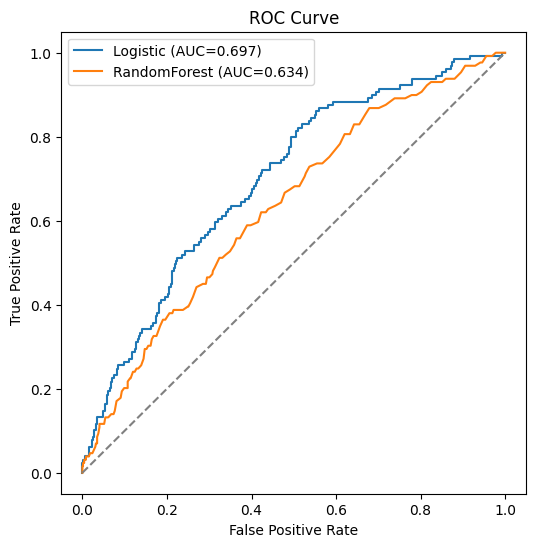

In [ ]:
# =============================
# STEP 10: ROC curves visualization
# =============================
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _   = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(6,6))
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC={roc_auc_score(y_test,y_prob_log):.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={roc_auc_score(y_test,y_prob_rf):.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Top 10 RF feature importances:
 age             0.173521
sysBP           0.116952
totChol         0.098187
diaBP           0.097407
heartRate       0.096703
education       0.093776
BMI             0.091704
glucose         0.091221
cigsPerDay      0.057239
prevalentHyp    0.029666
dtype: float64


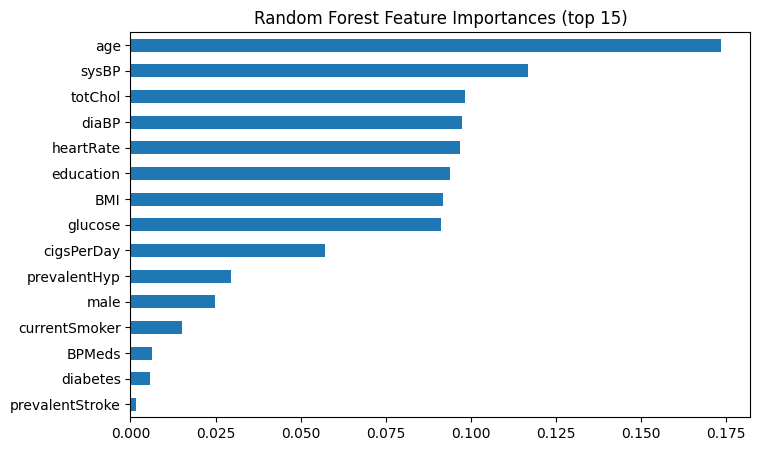

Top 10 Logistic coeffs (abs):
 age                0.691634
cigsPerDay         0.251504
sysBP              0.216527
male               0.204397
glucose            0.129711
BPMeds             0.109396
totChol            0.109258
diaBP              0.107022
prevalentStroke    0.079407
heartRate          0.066022
dtype: float64


In [ ]:
# =============================
# STEP 11: Feature importance (Random Forest) & Logistic coefficients
# =============================
# Random Forest importances
feat_imp = pd.Series(rf_clf.feature_importances_, index=X_scaled.columns).sort_values(ascending=False)
print("Top 10 RF feature importances:\n", feat_imp.head(10))

plt.figure(figsize=(8,5))
feat_imp.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importances (top 15)")
plt.show()

# Logistic Regression coefficients (absolute)
coeffs = pd.Series(np.abs(log_clf.coef_[0]), index=X_scaled.columns).sort_values(ascending=False)
print("Top 10 Logistic coeffs (abs):\n", coeffs.head(10))


In [ ]:
# =============================
# STEP 12: Cross-validation scores (5-fold)
# =============================
print("Logistic CV accuracy (5-fold):", cross_val_score(log_clf, X_scaled, y, cv=5, scoring='accuracy').mean())
print("RandomForest CV accuracy (5-fold):", cross_val_score(rf_clf, X_scaled, y, cv=5, scoring='accuracy').mean())


Logistic CV accuracy (5-fold): 0.6662735849056605
RandomForest CV accuracy (5-fold): 0.8504716981132076


In [ ]:
# =============================
# STEP 13: Hyperparameter tuning (Randomized/Grid) - example GridSearch
# NOTE: this can be slow; you can reduce param grid for speed
# =============================
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 6, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

gs = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'),
                  param_grid, cv=3, scoring='recall', n_jobs=-1, verbose=0)
gs.fit(X_train_bal, y_train_bal)

print("Best params (by recall):", gs.best_params_)
best_rf = gs.best_estimator_

# Evaluate tuned model
y_prob_best = best_rf.predict_proba(X_test)[:,1]
y_pred_best = best_rf.predict(X_test)
evaluate(y_test, y_pred_best, y_prob_best, "Tuned Random Forest")


Best params (by recall): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

=== Tuned Random Forest ===
Accuracy: 0.7900943396226415
Precision: 0.25742574257425743
Recall: 0.20155038759689922
F1-score: 0.22608695652173913
ROC-AUC: 0.6337721426184083
Confusion Matrix:
 [[644  75]
 [103  26]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8621    0.8957    0.8786       719
           1     0.2574    0.2016    0.2261       129

    accuracy                         0.7901       848
   macro avg     0.5598    0.5486    0.5523       848
weighted avg     0.7701    0.7901    0.7793       848



In [ ]:
# =============================
# STEP 14: Improve recall tips (threshold tuning)
# - You can raise recall by lowering classification threshold for positive class
# =============================
def threshold_metrics(y_true, y_prob, thresh=0.5):
    y_pred_thresh = (y_prob >= thresh).astype(int)
    return {
        'threshold': thresh,
        'precision': precision_score(y_true, y_pred_thresh),
        'recall': recall_score(y_true, y_pred_thresh),
        'f1': f1_score(y_true, y_pred_thresh),
        'accuracy': accuracy_score(y_true, y_pred_thresh)
    }

for t in [0.9,0.7,0.5,0.3,0.1]:
    print(threshold_metrics(y_test, y_prob_best, t))


{'threshold': 0.9, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.847877358490566}
{'threshold': 0.7, 'precision': 0.45454545454545453, 'recall': 0.03875968992248062, 'f1': 0.07142857142857142, 'accuracy': 0.8466981132075472}
{'threshold': 0.5, 'precision': 0.2524271844660194, 'recall': 0.20155038759689922, 'f1': 0.22413793103448276, 'accuracy': 0.7877358490566038}
{'threshold': 0.3, 'precision': 0.21710526315789475, 'recall': 0.5116279069767442, 'f1': 0.30484988452655887, 'accuracy': 0.6450471698113207}
{'threshold': 0.1, 'precision': 0.16830294530154277, 'recall': 0.9302325581395349, 'f1': 0.2850356294536817, 'accuracy': 0.29009433962264153}


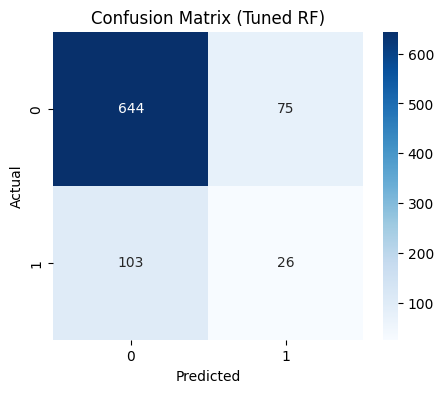

In [ ]:
# =============================
# STEP 15: Confusion matrix heatmap (Tuned RF)
# =============================
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Tuned RF)")
plt.show()
